In [1]:
import os

interface_dir = os.environ["DATA"] + "webinterfaces/exp02/"

tasks_dir = os.path.join(interface_dir, "res", "tasks")
results_dir = os.path.join(interface_dir, "results")
protocols_dir = os.path.join(interface_dir, "protocols")
prolific_matching_dir = os.path.join(interface_dir, "prolific")

protocol_paths_d = {
    "H": os.path.join(protocols_dir, "H_0.json"),
    "H+AI": os.path.join(protocols_dir, "AI_0.json"),
    "H+AI+CF": os.path.join(protocols_dir, "XAI_CF_0.json"),
    "H+AI+SHAP": os.path.join(protocols_dir, "XAI_SHAP_0.json"),
    "H+AI+LLM": os.path.join(protocols_dir, "XAI_LLM_0.json"),
    "H+AI+GRADCAM": os.path.join(protocols_dir, "XAI_GRADCAM_0.json"),
}

COMPREHENSION_THRESHOLD = 0.8

COMPREHENSION_TASKS = ["xeasy1_find_pattern_rot"]
TRAINING_TASKS = ["med3_find_pattern_rot"]
EASY_TASKS = ["easy1_find_pattern_rot", "easy3_find_pattern_rot"]
DIFFICULT_TASKS = ["hard1_find_pattern_rot", "hard3_find_pattern_rot"]

MILD_PRESSURE_TASKS = ["easy1_find_pattern_rot", "hard1_find_pattern_rot"]
STRONG_PRESSURE_TASKS = ["easy3_find_pattern_rot", "hard3_find_pattern_rot"]

TASK_PROTOCOL_KEYS = {
    "easy1_find_pattern_rot": "mainexp_easy_mild_patrot_task",
    "easy3_find_pattern_rot": "mainexp_easy_strong_patrot_task",

    "hard1_find_pattern_rot": "mainexp_hard_mild_patrot_task",
    "hard3_find_pattern_rot": "mainexp_hard_strong_patrot_task",

    "xeasy1_find_pattern_rot": "intro_comprehension_task",
    "med3_find_pattern_rot": "intro_training_1_task"
}


In [2]:
import sys

sys.path.append("/home/jleguy/Documents/postdoc/git_repos/WebXAII/")

In [3]:
import json
import csv
import numpy as np


def load_json(path):
    with open(path) as json_file:
        return json.load(json_file)


def load_task_csv_file(path):
    y_true, y_pred = [], []
    with open(path) as csv_data:
        reader = csv.DictReader(csv_data)
        for row in reader:
            y_true.append(int(row["target"]))
            y_pred.append(int(row["pred"]))

    return np.array(y_true), np.array(y_pred)


In [4]:
import json

def data_matching(protocols_paths_d, prolific_matching_files):

    results_filenames_d = {k: [] for k in protocol_paths_d.keys()}

    for prolific_matching_file in prolific_matching_files:

        with open(prolific_matching_file) as json_data:
            d = json.load(json_data)

            for prolific_id, prot_dict in d.items():
                condition_split = prot_dict["protocol"].split("_")
                filename = prolific_id + ".json"

                if condition_split[0] == "H":
                    results_filenames_d["H"].append(filename)
                elif condition_split[0] == "AI":
                    results_filenames_d["H+AI"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "SHAP":
                    results_filenames_d["H+AI+SHAP"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "CF":
                    results_filenames_d["H+AI+CF"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "LLM":
                    results_filenames_d["H+AI+LLM"].append(filename)
                elif condition_split[0] == "XAI" and condition_split[1] == "GRADCAM":
                    results_filenames_d["H+AI+GRADCAM"].append(filename)

    return results_filenames_d


In [5]:
from pywebxaii.resretrieval import extract_p_questionnaire_results, get_protocol_entry_from_key

def extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = {"raw": {}, "values": {}, "times": {}}

        # Iterating on all results files for the current group
        for filename in filenames_list:
            print(filename)
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            data_issue = False
            if not curr_res_d["is_completed"]:
                data_issue = True

            # Iterating over all questionnaires keys
            for quest_key in quest_keys:

                curr_protocol_d = load_json(protocol_paths_d[group_key])
                try:
                    get_protocol_entry_from_key(curr_protocol_d, quest_key)
                    answers_raw, answers_values, quest_times = extract_p_questionnaire_results(curr_res_d,
                                                                                               quest_key,
                                                                                               protocol_d=curr_protocol_d)
                except KeyError:
                    data_issue = True

                if quest_key not in output_res_d[group_key]["raw"]:
                    output_res_d[group_key]["raw"][quest_key] = []
                    output_res_d[group_key]["values"][quest_key] = []
                    output_res_d[group_key]["times"][quest_key] = []

                if data_issue:
                    output_res_d[group_key]["raw"][quest_key].append(None)
                    output_res_d[group_key]["values"][quest_key].append(None)
                    output_res_d[group_key]["times"][quest_key].append(None)
                else:
                    output_res_d[group_key]["raw"][quest_key].append(answers_raw)
                    output_res_d[group_key]["values"][quest_key].append(answers_values)
                    output_res_d[group_key]["times"][quest_key].append(quest_times)

    return output_res_d

In [6]:
from pywebxaii.resretrieval import extract_p_task_results


def compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, tasks_names, task_protocol_keys):
    output_res_scores_d = {}
    output_res_reliance_d = {}
    output_res_overreliance_d = {}
    output_res_underreliance_d = {}
    output_res_appropriate_reliance_d = {}
    output_res_answer_times_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_scores_d[group_key] = []
        output_res_reliance_d[group_key] = []
        output_res_overreliance_d[group_key] = []
        output_res_underreliance_d[group_key] = []
        output_res_appropriate_reliance_d[group_key] = []
        output_res_answer_times_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            print(filename)
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue

            nb_questions = 0
            nb_quest_wrong_predictions = 0
            nb_quest_right_predictions = 0
            nb_correct = 0
            nb_reliance = 0
            nb_overreliance = 0
            nb_underreliance = 0
            nb_appropriate = 0
            answer_times = []
            early_break = False

            # Iterating over all tasks
            for task_idx, task_name in enumerate(tasks_names):

                task_true, ai_pred = load_task_csv_file(os.path.join(tasks_dir, task_name + "_content.csv"))

                answers_idx_vect, answers_text_vect, time_vect, _, _ = \
                    extract_p_task_results(curr_res_d,
                                           task_protocol_keys[tasks_names[task_idx]],
                                           protocol_d=load_json(protocol_paths_d[group_key]))

                nb_questions += len(answers_idx_vect)
                nb_quest_wrong_predictions += np.sum(task_true != ai_pred)
                nb_quest_right_predictions += np.sum(task_true == ai_pred)

                try:
                    nb_correct += np.sum(answers_idx_vect == np.logical_not(task_true))
                    nb_reliance += np.sum(answers_idx_vect == np.logical_not(ai_pred))
                    nb_overreliance += np.sum(np.logical_and(
                        answers_idx_vect == np.logical_not(ai_pred),
                        ai_pred != task_true
                    ))
                    nb_underreliance += np.sum(np.logical_and(
                        answers_idx_vect != np.logical_not(ai_pred),
                        ai_pred == task_true
                    ))
                    answer_times.extend((np.array(time_vect)/1000).tolist())
                    #
                    # if np.isnan(np.sum(answers_idx_vect)):
                    #     print(f"answers {answers_idx_vect}")
                    #     print(f"true {np.logical_not(task_true)}")
                    #     print(f"ai pred {np.logical_not(ai_pred)}")
                    #     print(f"correct extracted {np.sum(answers_idx_vect == np.logical_not(task_true))}")
                    #     print(f"reliance extracted {np.sum(answers_idx_vect == np.logical_not(ai_pred))}")

                # Happens if the results file is not complete
                except ValueError:
                    print("ValueError exception")
                    output_res_scores_d[group_key].append(None)
                    output_res_reliance_d[group_key].append(None)
                    output_res_overreliance_d[group_key].append(None)
                    output_res_underreliance_d[group_key].append(None)
                    output_res_answer_times_d[group_key].append(None)
                    early_break = True
                    break

            if not early_break:
                output_res_scores_d[group_key].append(nb_correct / nb_questions)
                output_res_reliance_d[group_key].append(nb_reliance / nb_questions)
                output_res_overreliance_d[group_key].append(nb_overreliance / nb_quest_wrong_predictions)
                output_res_underreliance_d[group_key].append(nb_underreliance / nb_quest_right_predictions)
                output_res_answer_times_d[group_key].extend(answer_times)

    return output_res_scores_d, output_res_reliance_d, output_res_overreliance_d, output_res_underreliance_d, output_res_answer_times_d


In [7]:
results_filenames_d = data_matching(protocol_paths_d, [os.path.join(prolific_matching_dir, "prolific.json"),
                                                       os.path.join(prolific_matching_dir, "prolific_21-1.json")])
                                                       # os.path.join(prolific_matching_dir, "prolific_2_tmp.json")])

In [8]:
results_filenames_d

{'H': ['60017449682ed3025a873e3d.json',
  '5ce740c8636a5b0018f55968.json',
  '5a33e4a10758280001030ce5.json',
  '5bcb95ffb592580001ec24cf.json',
  '631745a70c7c585248df1a5d.json',
  '5fd8ea198512a801831f6b85.json',
  '5ab8c3fb9534ba0001c6b60d.json',
  '66d035e529e80315f590ecce.json',
  '5f1088e27a43fe0c64ca5814.json',
  '5eff5f05b92981000a2aed73.json',
  '5bc7a4433dec25000138c626.json',
  '5cae3e6a47494e0018328cbb.json',
  '66d4407f31981698998d25d8.json',
  '666445e5b72745f04a4f57d6.json',
  '6016f0e16f7aec8af4152aa4.json',
  '66c9f7305f8a64d04cb5344c.json',
  '6105ba07b4fa0867eaed2f5b.json',
  '6658b23d488052210af6eb17.json',
  '5fe0b183d8918b2030aa99a0.json',
  '6777c88074566bdef374f9e5.json',
  '66bdde69417a86ba178f7871.json',
  '5cfbf333ac28dd00196e807b.json',
  '66dd8fd2905d609d29ccf008.json',
  '60a7af637db81b5c05648d92.json',
  '613dd5fb512aabe8d5d32393 .json',
  '5b2e41eb1d2f710001fb32db.json',
  '5b2a2d855b5c0900018b0bf5.json',
  '671c1c699ca32031a83014e8.json',
  '665dc46f655

In [9]:
total = 0
for k, v in results_filenames_d.items():
    total+=len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 34
H+AI: 34
H+AI+CF: 30
H+AI+SHAP: 33
H+AI+LLM: 33
H+AI+GRADCAM: 31
Total: 195


In [10]:
def filter_not_completed(results_filenames_d):
    filtered_results_filenames_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        filtered_results_filenames_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue
            filtered_results_filenames_d[group_key].append(filename)
    return filtered_results_filenames_d

In [11]:
results_filenames_d = filter_not_completed(results_filenames_d)

In [12]:
results_filenames_before_filtering = dict(results_filenames_d)

In [13]:
total = 0
for k, v in results_filenames_d.items():
    total+=len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 27
H+AI: 31
H+AI+CF: 26
H+AI+SHAP: 29
H+AI+LLM: 29
H+AI+GRADCAM: 25
Total: 167


In [14]:
def filter_on_attention_tests(results_filenames_d):
    res = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_1", "attentioncheck_2"])
    filtered_results_filenames_d = {}

    for k, v in res.items():
        filtered_results_filenames_d[k] = []
        for i in range(len(results_filenames_d[k])):
            if v["raw"]["attentioncheck_1"][i] is None:
                passes1 = False
            else:
                passes1 = v["raw"]["attentioncheck_1"][i][0] == 2 and v["raw"]["attentioncheck_1"][i][1] == 0


            if v["raw"]["attentioncheck_2"][i] is None:
                passes2 = False
            else:
                passes2 = v["raw"]["attentioncheck_2"][i][0] == 6 and v["raw"]["attentioncheck_2"][i][1] == 0

            if passes1 and passes2:
                filtered_results_filenames_d[k].append(results_filenames_d[k][i])

    return filtered_results_filenames_d

In [15]:
results_filenames_d = filter_on_attention_tests(results_filenames_d)

5a33e4a10758280001030ce5.json
5bcb95ffb592580001ec24cf.json
631745a70c7c585248df1a5d.json
5fd8ea198512a801831f6b85.json
5ab8c3fb9534ba0001c6b60d.json
66d035e529e80315f590ecce.json
5f1088e27a43fe0c64ca5814.json
5cae3e6a47494e0018328cbb.json
66d4407f31981698998d25d8.json
666445e5b72745f04a4f57d6.json
6016f0e16f7aec8af4152aa4.json
66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
613dd5fb512aabe8d5d32393 .json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
631b41500bed6fddcc87c089.json
62d6d77df59450e545fb22f6.json
5a8f01d95292b80001235d34.json
5d0e091ccd9c9300191cb9c9.json
670426ac729d4ec0254bedd8.json
5cdd4befd3651c001950e539.json
674377f77b539c33d343553c.json
66928f171

In [16]:
total = 0
for k, v in results_filenames_d.items():
    total+=len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 24
H+AI: 29
H+AI+CF: 26
H+AI+SHAP: 27
H+AI+LLM: 29
H+AI+GRADCAM: 25
Total: 160


In [17]:
def filter_comprehension_score(results_filenames_d):
    comprehension_score_d, _, _, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, COMPREHENSION_TASKS, TASK_PROTOCOL_KEYS)
    filtered_results_filenames_d = {}

    for k, v in comprehension_score_d.items():
        filtered_results_filenames_d[k] = []
        for i in range(len(results_filenames_d[k])):
            if comprehension_score_d[k][i] >= COMPREHENSION_THRESHOLD:
                filtered_results_filenames_d[k].append(results_filenames_d[k][i])
            else:
                print(f"Rejecting sample due to comprehension score of {comprehension_score_d[k][i]}")

    return filtered_results_filenames_d


In [18]:
results_filenames_d = filter_comprehension_score(results_filenames_d)

5a33e4a10758280001030ce5.json
5bcb95ffb592580001ec24cf.json
631745a70c7c585248df1a5d.json
5fd8ea198512a801831f6b85.json
66d035e529e80315f590ecce.json
5f1088e27a43fe0c64ca5814.json
5cae3e6a47494e0018328cbb.json
666445e5b72745f04a4f57d6.json
6016f0e16f7aec8af4152aa4.json
66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
613dd5fb512aabe8d5d32393 .json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
62d6d77df59450e545fb22f6.json
5a8f01d95292b80001235d34.json
5d0e091ccd9c9300191cb9c9.json
670426ac729d4ec0254bedd8.json
5cdd4befd3651c001950e539.json
674377f77b539c33d343553c.json
66928f171518765c5f8cea5b.json
60537fdcda0ac05f1c59c57f.json
5f75d01a857e4e27a575f7ca.json
5bb756696

In [19]:
total = 0
for k, v in results_filenames_d.items():
    total+=len(v)
    print(f"{k}: {len(v)}")
print(f"Total: {total}")

H: 23
H+AI: 26
H+AI+CF: 26
H+AI+SHAP: 24
H+AI+LLM: 24
H+AI+GRADCAM: 23
Total: 146


In [20]:
print(f"Total passing filters among complete files: {np.sum([len(v) for v in results_filenames_d.values()])}/{np.sum([len(v) for v in results_filenames_before_filtering.values()])}")

Total passing filters among complete files: 146/167


In [21]:
all_scores, all_reliance, all_overreliance, all_underreliance, all_times = compute_scores(results_dir, results_filenames_d, protocol_paths_d,
                                                            tasks_dir,
                                                            EASY_TASKS + DIFFICULT_TASKS, TASK_PROTOCOL_KEYS)

all_scores_easy, all_reliance_easy, all_overreliance_easy, all_underreliance_easy, all_times_easy = compute_scores(results_dir, results_filenames_d,
                                                                           protocol_paths_d, tasks_dir,
                                                                           EASY_TASKS, TASK_PROTOCOL_KEYS)

all_scores_difficult, all_reliance_difficult, all_overreliance_difficult, all_underreliance_difficult, all_times_difficult = compute_scores(results_dir,
                                                                                          results_filenames_d,
                                                                                          protocol_paths_d,
                                                                                          tasks_dir, DIFFICULT_TASKS,
                                                                                          TASK_PROTOCOL_KEYS)

all_scores_mild, all_reliance_mild, all_overreliance_mild, all_underreliance_mild, all_times_mild = compute_scores(results_dir, results_filenames_d,
                                                                           protocol_paths_d, tasks_dir,
                                                                           MILD_PRESSURE_TASKS,
                                                                           TASK_PROTOCOL_KEYS)

all_scores_strong, all_reliance_strong, all_overreliance_strong, all_underreliance_strong, all_times_strong = compute_scores(results_dir, results_filenames_d,
                                                                                 protocol_paths_d, tasks_dir,
                                                                                 STRONG_PRESSURE_TASKS,
                                                                                 TASK_PROTOCOL_KEYS)

comprehension_score, _, _, _, _ = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, COMPREHENSION_TASKS, TASK_PROTOCOL_KEYS)

# all_scores_findpatterns, all_reliance_findpatterns, all_overreliance_findpatterns = compute_scores(results_dir,
#                                                                                                    results_filenames_d,
#                                                                                                    protocol_paths_d,
#                                                                                                    tasks_dir,
#                                                                                                    FIND_PATTERNS_TASKS,
#                                                                                                    TASK_PROTOCOL_KEYS)
# all_scores_countsym, all_reliance_countsym, all_overreliance_countsym = compute_scores(results_dir, results_filenames_d,
#                                                                                        protocol_paths_d,
#                                                                                        tasks_dir, COUNT_SYMBOLS_TASKS,
#                                                                                        TASK_PROTOCOL_KEYS)

5a33e4a10758280001030ce5.json
5bcb95ffb592580001ec24cf.json
631745a70c7c585248df1a5d.json
5fd8ea198512a801831f6b85.json
66d035e529e80315f590ecce.json
5f1088e27a43fe0c64ca5814.json
5cae3e6a47494e0018328cbb.json
666445e5b72745f04a4f57d6.json
6016f0e16f7aec8af4152aa4.json
66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
62d6d77df59450e545fb22f6.json
5a8f01d95292b80001235d34.json
5d0e091ccd9c9300191cb9c9.json
670426ac729d4ec0254bedd8.json
5cdd4befd3651c001950e539.json
674377f77b539c33d343553c.json
66928f171518765c5f8cea5b.json
60537fdcda0ac05f1c59c57f.json
5f75d01a857e4e27a575f7ca.json
5bb756696322c5000159756c.json
62b0a3fa60

In [22]:
all_scores

{'H': [0.7291666666666666,
  0.7708333333333334,
  0.7083333333333334,
  0.7708333333333334,
  0.6666666666666666,
  0.7083333333333334,
  0.8333333333333334,
  0.6666666666666666,
  0.7916666666666666,
  0.625,
  0.6875,
  0.8125,
  0.7916666666666666,
  0.7916666666666666,
  0.6666666666666666,
  0.7291666666666666,
  0.7916666666666666,
  0.7083333333333334,
  0.4791666666666667,
  0.6875,
  0.7083333333333334,
  0.75,
  0.8333333333333334],
 'H+AI': [0.6041666666666666,
  0.7708333333333334,
  0.7916666666666666,
  0.75,
  0.7916666666666666,
  0.7291666666666666,
  0.8125,
  0.7916666666666666,
  0.7708333333333334,
  0.7916666666666666,
  0.7708333333333334,
  0.8541666666666666,
  0.7916666666666666,
  0.8541666666666666,
  0.8125,
  0.6875,
  0.8125,
  0.8958333333333334,
  0.9375,
  0.875,
  0.9375,
  0.7708333333333334,
  0.8541666666666666,
  0.9166666666666666,
  0.875,
  0.7916666666666666],
 'H+AI+CF': [0.8333333333333334,
  0.7916666666666666,
  0.8333333333333334,
  0.7

In [23]:
all_scores_easy

{'H': [0.8333333333333334,
  0.9166666666666666,
  0.875,
  0.75,
  0.7916666666666666,
  0.7916666666666666,
  0.9166666666666666,
  0.75,
  0.9166666666666666,
  0.7916666666666666,
  0.875,
  0.875,
  0.9166666666666666,
  0.9166666666666666,
  0.7083333333333334,
  0.7916666666666666,
  0.875,
  0.875,
  0.4583333333333333,
  0.7083333333333334,
  0.7916666666666666,
  0.75,
  0.9166666666666666],
 'H+AI': [0.5416666666666666,
  0.875,
  0.7916666666666666,
  0.7083333333333334,
  0.7916666666666666,
  0.875,
  0.9583333333333334,
  0.8333333333333334,
  0.875,
  0.7916666666666666,
  0.875,
  0.875,
  0.7916666666666666,
  0.8333333333333334,
  0.7916666666666666,
  0.7916666666666666,
  0.8333333333333334,
  0.9583333333333334,
  0.9583333333333334,
  0.9166666666666666,
  0.9583333333333334,
  0.7916666666666666,
  0.875,
  0.9583333333333334,
  0.875,
  0.875],
 'H+AI+CF': [0.875,
  0.9166666666666666,
  0.8333333333333334,
  0.7916666666666666,
  0.8333333333333334,
  0.958333

In [24]:
all_scores_difficult

{'H': [0.625,
  0.625,
  0.5416666666666666,
  0.7916666666666666,
  0.5416666666666666,
  0.625,
  0.75,
  0.5833333333333334,
  0.6666666666666666,
  0.4583333333333333,
  0.5,
  0.75,
  0.6666666666666666,
  0.6666666666666666,
  0.625,
  0.6666666666666666,
  0.7083333333333334,
  0.5416666666666666,
  0.5,
  0.6666666666666666,
  0.625,
  0.75,
  0.75],
 'H+AI': [0.6666666666666666,
  0.6666666666666666,
  0.7916666666666666,
  0.7916666666666666,
  0.7916666666666666,
  0.5833333333333334,
  0.6666666666666666,
  0.75,
  0.6666666666666666,
  0.7916666666666666,
  0.6666666666666666,
  0.8333333333333334,
  0.7916666666666666,
  0.875,
  0.8333333333333334,
  0.5833333333333334,
  0.7916666666666666,
  0.8333333333333334,
  0.9166666666666666,
  0.8333333333333334,
  0.9166666666666666,
  0.75,
  0.8333333333333334,
  0.875,
  0.875,
  0.7083333333333334],
 'H+AI+CF': [0.7916666666666666,
  0.6666666666666666,
  0.8333333333333334,
  0.625,
  0.7916666666666666,
  0.8333333333333

In [25]:
comprehension_score

{'H': [1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8],
 'H+AI': [0.8,
  1.0,
  0.8,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0],
 'H+AI+CF': [1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0],
 'H+AI+SHAP': [0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0],
 'H+AI+LLM': [1.0,
  0.8,
  0.8,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  1.0,
  0.8,
  1.0,
  0.8,
  0.8],
 'H+AI+GRADCAM': [1.0,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  0.8,
  1.0,
  1.0,

In [26]:
data_scores_difficulty = {
    "easy tasks": all_scores_easy,
    "difficult tasks": all_scores_difficult,
}

data_scores_pressure = {
    "mild pressure tasks": all_scores_mild,
    "strong pressure tasks": all_scores_strong,
}

In [27]:
all_scores_training, all_reliance_training, all_overreliance_training, all_underreliance_training, _ = compute_scores(results_dir, results_filenames_d,
                                                                                                                   protocol_paths_d, tasks_dir,
                                                                                                                    TRAINING_TASKS, TASK_PROTOCOL_KEYS)

5a33e4a10758280001030ce5.json
5bcb95ffb592580001ec24cf.json
631745a70c7c585248df1a5d.json
5fd8ea198512a801831f6b85.json
66d035e529e80315f590ecce.json
5f1088e27a43fe0c64ca5814.json
5cae3e6a47494e0018328cbb.json
666445e5b72745f04a4f57d6.json
6016f0e16f7aec8af4152aa4.json
66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
62d6d77df59450e545fb22f6.json
5a8f01d95292b80001235d34.json
5d0e091ccd9c9300191cb9c9.json
670426ac729d4ec0254bedd8.json
5cdd4befd3651c001950e539.json
674377f77b539c33d343553c.json
66928f171518765c5f8cea5b.json
60537fdcda0ac05f1c59c57f.json
5f75d01a857e4e27a575f7ca.json
5bb756696322c5000159756c.json
62b0a3fa60

In [28]:
all_scores_training

{'H': [0.6,
  0.8,
  1.0,
  0.6,
  1.0,
  0.8,
  1.0,
  0.8,
  1.0,
  1.0,
  0.6,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.8,
  0.8,
  0.8,
  0.8,
  0.8],
 'H+AI': [0.6,
  1.0,
  1.0,
  0.8,
  0.6,
  0.8,
  0.8,
  1.0,
  1.0,
  0.8,
  0.8,
  1.0,
  0.6,
  0.8,
  0.6,
  0.4,
  1.0,
  1.0,
  0.6,
  0.8,
  0.8,
  0.8,
  0.8,
  0.8,
  1.0,
  0.8],
 'H+AI+CF': [0.8,
  1.0,
  0.8,
  1.0,
  0.8,
  0.8,
  1.0,
  1.0,
  0.8,
  0.8,
  0.8,
  0.8,
  0.8,
  0.8,
  0.8,
  0.8,
  1.0,
  0.6,
  0.8,
  0.8,
  1.0,
  0.8,
  1.0,
  0.8,
  1.0,
  0.8],
 'H+AI+SHAP': [0.8,
  1.0,
  0.8,
  0.8,
  0.8,
  1.0,
  0.8,
  0.8,
  1.0,
  1.0,
  1.0,
  1.0,
  0.6,
  1.0,
  0.8,
  1.0,
  0.8,
  0.8,
  1.0,
  0.8,
  0.6,
  1.0,
  1.0,
  0.8],
 'H+AI+LLM': [1.0,
  0.6,
  0.8,
  0.8,
  0.8,
  1.0,
  0.6,
  0.6,
  1.0,
  0.8,
  1.0,
  1.0,
  0.8,
  0.8,
  0.8,
  0.8,
  1.0,
  1.0,
  0.8,
  0.8,
  0.8,
  0.8,
  1.0,
  1.0],
 'H+AI+GRADCAM': [1.0,
  0.8,
  1.0,
  0.8,
  1.0,
  0.8,
  0.8,
  1.0,
  0.6,
  0.8,

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_boxplot(data, group_name, title="Group Box Plot", y_lim=None, y_line=None, figsize=(7, 4)):
    """
    Seaborn version of grouped boxplots.
    Data format:
        {"group1": [...], "group2": [...], ...}
    """

    # Convert dict into a DataFrame
    rows = []
    for group, values in data.items():
        for v in values:
            rows.append({group_name: group, "value": v})
    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value"
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def scatter_groups_nested(data, outer_name, inner_name, title="Group Scatter Plot", y_lim=None, y_line=None, figsize=(7,4)):
    """
    Seaborn version of scatter_groups_nested.
    Data format:
        {
            "outerGroup1": {"innerA": [...], "innerB": [...], ...},
            "outerGroup2": {"innerA": [...], "innerB": [...], ...},
        }
    Outer group = color
    Inner group = x-axis category
    """

    # Flatten into DataFrame
    rows = []
    for outer, inner_dict in data.items():
        for inner, values in inner_dict.items():
            for v in values:
                rows.append({
                    outer_name: outer,
                    inner_name: inner,
                    "value": v
                })
    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.scatterplot(
        data=df,
        x=inner_name,
        y="value",
        hue=outer_name,
        style=outer_name,  # keeps outer groups visually separated
        s=50
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_boxplot_two(
        data1,
        data2,
        group_name,
        dataset_name="Dataset",
        labels=("A", "B"),
        title="Group Box Plot",
        y_lim=None,
        y_line=None,
        figsize=(7, 4),
):
    """
    Seaborn version of grouped side-by-side boxplots.

    Data format:
        data1 = {"group1": [...], "group2": [...], ...}
        data2 = {"group1": [...], "group2": [...], ...}
    """

    rows = []

    for group, values in data1.items():
        for v in values:
            rows.append({group_name: group, "value": v, dataset_name: labels[0]})

    for group, values in data2.items():
        for v in values:
            rows.append({group_name: group, "value": v, dataset_name: labels[1]})

    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value",
        hue=dataset_name
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_boxplot_nested(
        data,
        group_name,
        dataset_name="Dataset",
        title="Group Box Plot",
        y_lim=None,
        y_line=None,
        figsize=(7, 4),
):
    rows = []

    for dataset, groups in data.items():
        for group, values in groups.items():
            for v in values:
                rows.append({
                    group_name: group,
                    "value": v,
                    dataset_name: dataset
                })

    df = pd.DataFrame(rows)

    plt.figure(figsize=figsize)

    sns.boxplot(
        data=df,
        x=group_name,
        y="value",
        hue=dataset_name
    )

    if y_line is not None:
        plt.axhline(y_line, color="black", linestyle="--", linewidth=1)

    plt.ylabel("Value")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.tight_layout()
    plt.show()




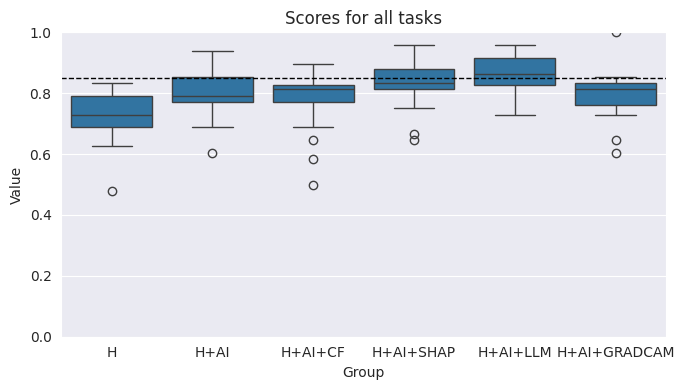

In [30]:
plot_boxplot(all_scores, group_name="Group", title="Scores for all tasks", y_lim=(0, 1), y_line=0.85)


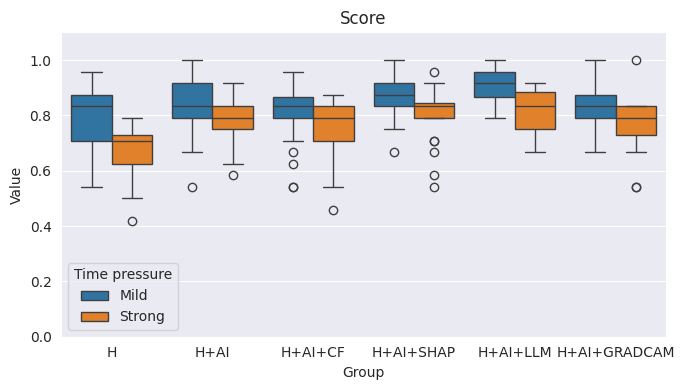

In [31]:
plot_boxplot_two(all_scores_mild, all_scores_strong, "Group", labels=["Mild", "Strong"], title="Score", dataset_name="Time pressure", y_lim=(0, 1.1))

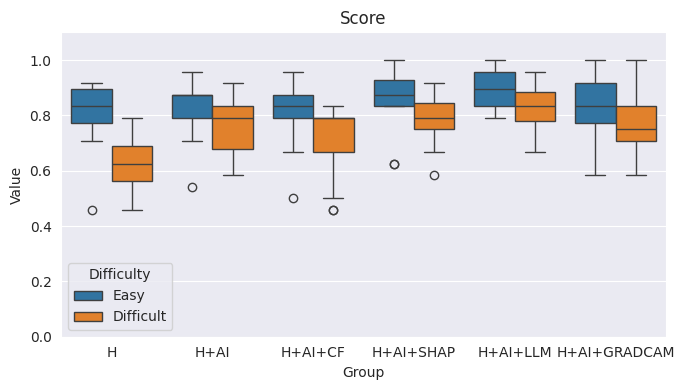

In [32]:
plot_boxplot_two(all_scores_easy, all_scores_difficult, "Group", labels=["Easy", "Difficult"], title="Score", dataset_name="Difficulty", y_lim=(0, 1.1))

In [33]:
all_reliance, all_overreliance

({'H': [0.6458333333333334,
   0.6666666666666666,
   0.625,
   0.6875,
   0.625,
   0.625,
   0.75,
   0.625,
   0.625,
   0.5833333333333334,
   0.7291666666666666,
   0.7708333333333334,
   0.7083333333333334,
   0.7083333333333334,
   0.625,
   0.6458333333333334,
   0.625,
   0.6041666666666666,
   0.5416666666666666,
   0.6875,
   0.5833333333333334,
   0.625,
   0.7083333333333334],
  'H+AI': [0.6875,
   0.6875,
   0.8958333333333334,
   0.7916666666666666,
   0.8125,
   0.8125,
   0.8125,
   0.8333333333333334,
   0.75,
   0.7708333333333334,
   0.8958333333333334,
   0.8125,
   0.6875,
   0.8541666666666666,
   0.9791666666666666,
   0.7083333333333334,
   0.7708333333333334,
   0.8125,
   0.8958333333333334,
   0.9583333333333334,
   0.875,
   0.8541666666666666,
   0.9791666666666666,
   0.875,
   0.7083333333333334,
   0.7916666666666666],
  'H+AI+CF': [0.9583333333333334,
   0.6666666666666666,
   0.9166666666666666,
   0.625,
   0.75,
   0.8541666666666666,
   0.770833333

In [34]:
all_reliance_easy, all_overreliance_easy

({'H': [0.75,
   0.75,
   0.75,
   0.75,
   0.625,
   0.625,
   0.8333333333333334,
   0.6666666666666666,
   0.75,
   0.625,
   0.7916666666666666,
   0.7916666666666666,
   0.75,
   0.8333333333333334,
   0.5833333333333334,
   0.7083333333333334,
   0.7083333333333334,
   0.7083333333333334,
   0.5833333333333334,
   0.7083333333333334,
   0.625,
   0.5833333333333334,
   0.75],
  'H+AI': [0.7083333333333334,
   0.75,
   0.8333333333333334,
   0.625,
   0.75,
   0.875,
   0.875,
   0.8333333333333334,
   0.7916666666666666,
   0.6666666666666666,
   0.9583333333333334,
   0.7916666666666666,
   0.625,
   0.75,
   0.9583333333333334,
   0.75,
   0.6666666666666666,
   0.7916666666666666,
   0.875,
   0.9166666666666666,
   0.875,
   0.875,
   0.9583333333333334,
   0.875,
   0.7083333333333334,
   0.875],
  'H+AI+CF': [0.9583333333333334,
   0.75,
   0.8333333333333334,
   0.7083333333333334,
   0.6666666666666666,
   0.7916666666666666,
   0.75,
   0.875,
   1.0,
   0.70833333333333

In [35]:
all_reliance_difficult, all_overreliance_difficult

({'H': [0.5416666666666666,
   0.5833333333333334,
   0.5,
   0.625,
   0.625,
   0.625,
   0.6666666666666666,
   0.5833333333333334,
   0.5,
   0.5416666666666666,
   0.6666666666666666,
   0.75,
   0.6666666666666666,
   0.5833333333333334,
   0.6666666666666666,
   0.5833333333333334,
   0.5416666666666666,
   0.5,
   0.5,
   0.6666666666666666,
   0.5416666666666666,
   0.6666666666666666,
   0.6666666666666666],
  'H+AI': [0.6666666666666666,
   0.625,
   0.9583333333333334,
   0.9583333333333334,
   0.875,
   0.75,
   0.75,
   0.8333333333333334,
   0.7083333333333334,
   0.875,
   0.8333333333333334,
   0.8333333333333334,
   0.75,
   0.9583333333333334,
   1.0,
   0.6666666666666666,
   0.875,
   0.8333333333333334,
   0.9166666666666666,
   1.0,
   0.875,
   0.8333333333333334,
   1.0,
   0.875,
   0.7083333333333334,
   0.7083333333333334],
  'H+AI+CF': [0.9583333333333334,
   0.5833333333333334,
   1.0,
   0.5416666666666666,
   0.8333333333333334,
   0.9166666666666666,
  

In [36]:
all_reliance_mild, all_overreliance_mild

({'H': [0.6666666666666666,
   0.6666666666666666,
   0.75,
   0.7916666666666666,
   0.5833333333333334,
   0.6666666666666666,
   0.75,
   0.6666666666666666,
   0.7083333333333334,
   0.5416666666666666,
   0.7916666666666666,
   0.7083333333333334,
   0.7916666666666666,
   0.7916666666666666,
   0.75,
   0.6666666666666666,
   0.6666666666666666,
   0.6666666666666666,
   0.5833333333333334,
   0.6666666666666666,
   0.5833333333333334,
   0.625,
   0.7916666666666666],
  'H+AI': [0.625,
   0.7916666666666666,
   1.0,
   0.7916666666666666,
   0.7083333333333334,
   0.8333333333333334,
   0.75,
   0.7916666666666666,
   0.7083333333333334,
   0.75,
   0.8333333333333334,
   0.6666666666666666,
   0.6666666666666666,
   0.8333333333333334,
   1.0,
   0.5833333333333334,
   0.75,
   0.75,
   0.8333333333333334,
   0.9166666666666666,
   0.875,
   0.7083333333333334,
   0.9583333333333334,
   0.7916666666666666,
   0.7916666666666666,
   0.75],
  'H+AI+CF': [1.0,
   0.75,
   0.916666

In [37]:
all_reliance_strong, all_overreliance_strong

({'H': [0.625,
   0.6666666666666666,
   0.5,
   0.5833333333333334,
   0.6666666666666666,
   0.5833333333333334,
   0.75,
   0.5833333333333334,
   0.5416666666666666,
   0.625,
   0.6666666666666666,
   0.8333333333333334,
   0.625,
   0.625,
   0.5,
   0.625,
   0.5833333333333334,
   0.5416666666666666,
   0.5,
   0.7083333333333334,
   0.5833333333333334,
   0.625,
   0.625],
  'H+AI': [0.75,
   0.5833333333333334,
   0.7916666666666666,
   0.7916666666666666,
   0.9166666666666666,
   0.7916666666666666,
   0.875,
   0.875,
   0.7916666666666666,
   0.7916666666666666,
   0.9583333333333334,
   0.9583333333333334,
   0.7083333333333334,
   0.875,
   0.9583333333333334,
   0.8333333333333334,
   0.7916666666666666,
   0.875,
   0.9583333333333334,
   1.0,
   0.875,
   1.0,
   1.0,
   0.9583333333333334,
   0.625,
   0.8333333333333334],
  'H+AI+CF': [0.9166666666666666,
   0.5833333333333334,
   0.9166666666666666,
   0.5416666666666666,
   0.7916666666666666,
   0.83333333333333

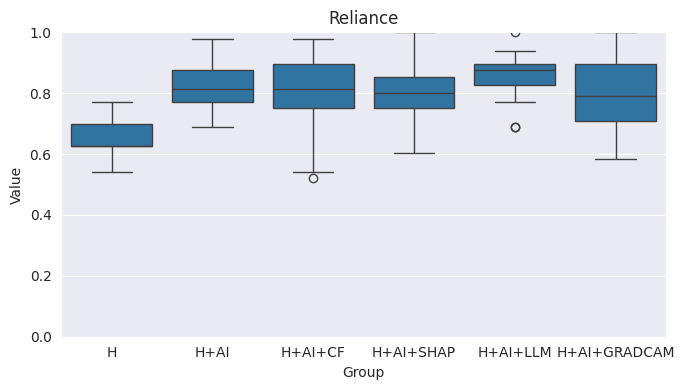

In [38]:
plot_boxplot(all_reliance, "Group", title="Reliance", y_lim=(0, 1))


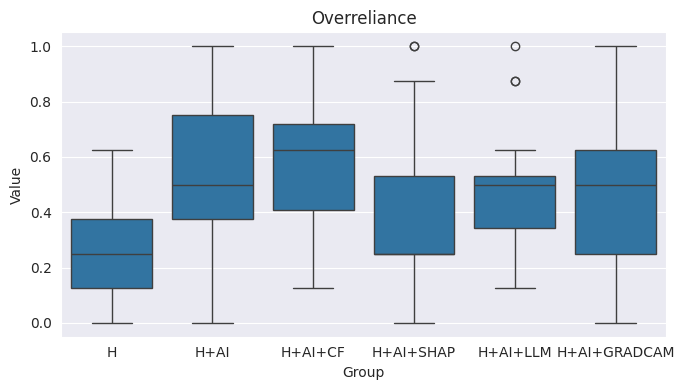

In [39]:
plot_boxplot(all_overreliance, "Group", title="Overreliance")


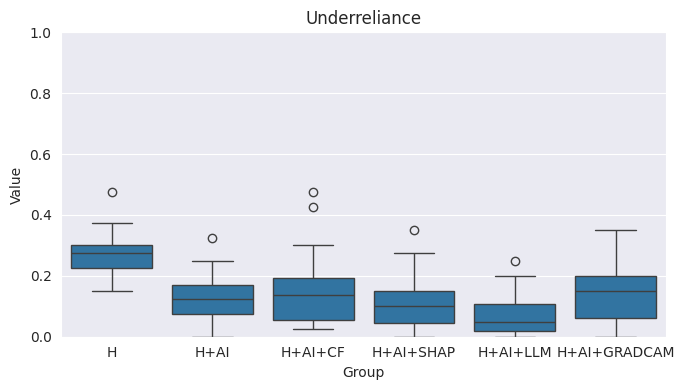

In [40]:
plot_boxplot(all_underreliance, "Group", title="Underreliance", y_lim=(0, 1))


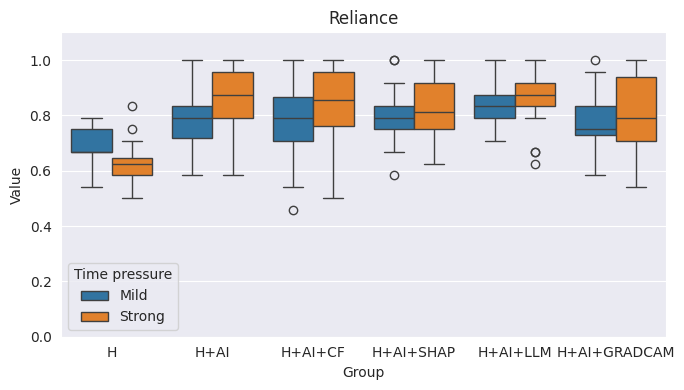

In [41]:
plot_boxplot_two(all_reliance_mild, all_reliance_strong, "Group", labels=["Mild", "Strong"], title="Reliance", dataset_name="Time pressure", y_lim=(0, 1.1))

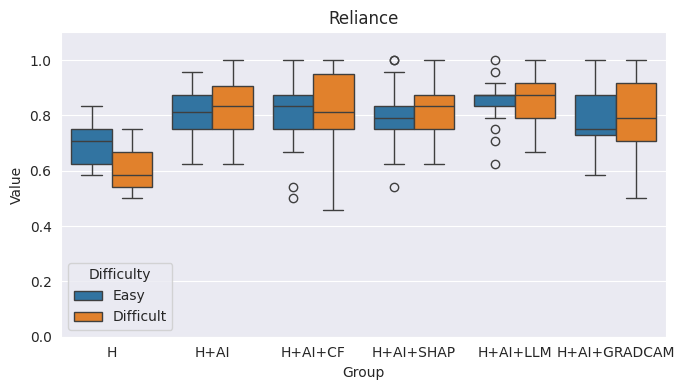

In [42]:
plot_boxplot_two(all_reliance_easy, all_reliance_difficult, "Group", labels=["Easy", "Difficult"], title="Reliance", dataset_name="Difficulty", y_lim=(0, 1.1))

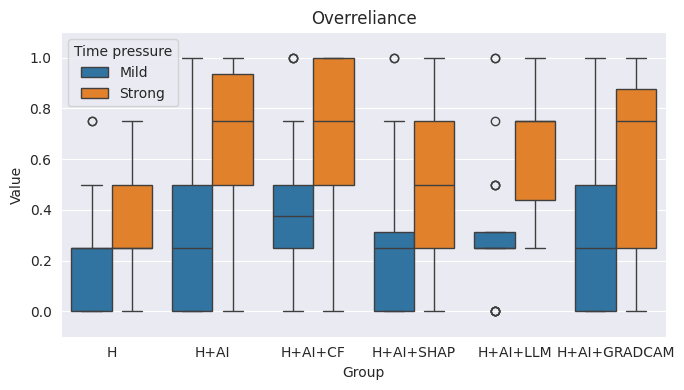

In [43]:
plot_boxplot_two(all_overreliance_mild, all_overreliance_strong, "Group", labels=["Mild", "Strong"], title="Overreliance", dataset_name="Time pressure",
                 y_lim=(-0.1, 1.1))

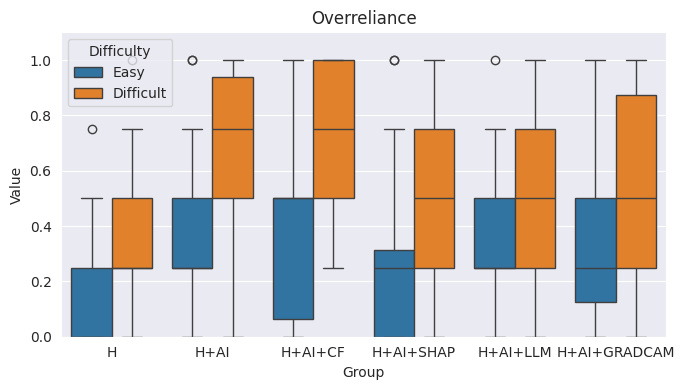

In [44]:
plot_boxplot_two(all_overreliance_easy, all_overreliance_difficult, "Group", labels=["Easy", "Difficult"], title="Overreliance", dataset_name="Difficulty", y_lim=(0, 1.1))

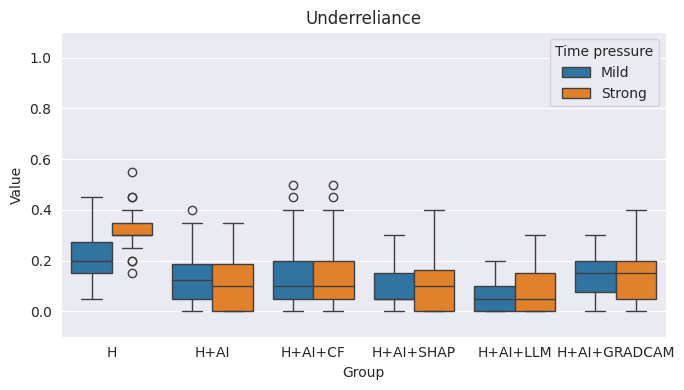

In [45]:
plot_boxplot_two(all_underreliance_mild, all_underreliance_strong, "Group", labels=["Mild", "Strong"], title="Underreliance", dataset_name="Time pressure",
                 y_lim=(-0.1, 1.1))

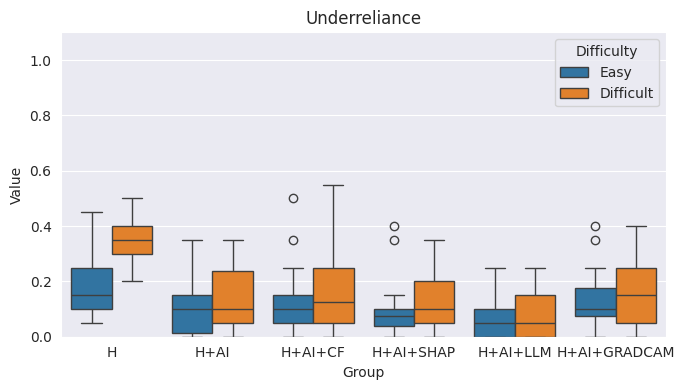

In [46]:
plot_boxplot_two(all_underreliance_easy, all_underreliance_difficult, "Group", labels=["Easy", "Difficult"], title="Underreliance", dataset_name="Difficulty", y_lim=(0, 1.1))

In [47]:
from pywebxaii.resretrieval import extract_total_times


def extract_times(results_dir, results_filenames_d):
    output_res_d = {}

    # Iterating over all groups
    for group_key, filenames_list in results_filenames_d.items():

        output_res_d[group_key] = []

        # Iterating on all results files for the current group
        for filename in filenames_list:
            curr_res_path = os.path.join(results_dir, filename)
            curr_res_d = load_json(curr_res_path)
            if not curr_res_d["is_completed"]:
                continue
            res_dict = load_json(curr_res_path)
            total_time, _ = extract_total_times(res_dict)

            output_res_d[group_key].append(total_time / 60)

    return output_res_d


In [48]:
times_data = extract_times(results_dir, results_filenames_d)

In [49]:
times_data

{'H': [14.670433333333333,
  17.168266666666668,
  26.6554,
  18.498866666666668,
  21.0865,
  18.809833333333334,
  16.586466666666666,
  27.06978333333333,
  17.834766666666667,
  10.238266666666668,
  10.30855,
  15.081633333333334,
  14.88795,
  21.72961666666667,
  26.306233333333335,
  19.686500000000002,
  19.642400000000002,
  21.46033333333333,
  15.41505,
  11.997616666666666,
  15.66605,
  18.0596,
  16.037616666666665],
 'H+AI': [27.02011666666667,
  16.070183333333333,
  19.052500000000002,
  21.8294,
  23.99405,
  29.8684,
  31.21675,
  17.215933333333332,
  23.957516666666667,
  18.838783333333332,
  13.956733333333334,
  24.233183333333333,
  18.767916666666668,
  15.68115,
  23.29413333333333,
  18.800416666666667,
  27.691066666666664,
  19.127799999999997,
  18.792983333333332,
  20.473533333333332,
  20.466283333333333,
  17.026766666666667,
  35.46491666666667,
  18.764833333333335,
  21.614050000000002,
  18.0231],
 'H+AI+CF': [18.610383333333335,
  23.71703333333

In [50]:
alltimes = []
for k, v in times_data.items():
    alltimes.extend(v)
print({f"median : {np.median(alltimes)}"})

{'median : 19.988875'}


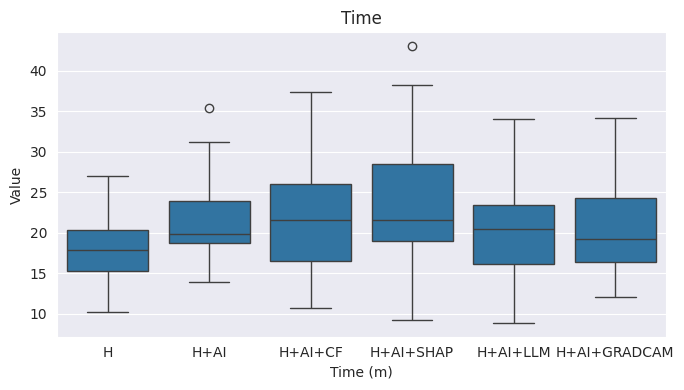

In [51]:
plot_boxplot(times_data, "Time (m)", title="Time")


In [52]:
def process_cogload(cogload_results):
    output_d = {}
    for k, v in cogload_results.items():
        output_d[k] = {}
        for session_id, results_list in v["raw"].items():

            if session_id == "mainexp_easy_mild_cogload":
                session_name = "easy;mild"
            elif session_id == "mainexp_easy_strong_cogload":
                session_name = "easy;strong"
            elif session_id == "mainexp_hard_mild_cogload":
                session_name = "hard;mild"
            elif session_id == "mainexp_hard_strong_cogload":
                session_name = "hard;strong"

            if session_id not in output_d:
                output_d[k][session_name] = []
            for result_arr in results_list:
                output_d[k][session_name].append(np.sum(result_arr))

    return output_d


In [ ]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

In [425]:
# cogload_results

In [426]:
cogload_processed = process_cogload(cogload_results)

In [427]:
cogload_processed

{'H': {'easy;mild': [14, 16, 18, 24, 22, 12, 17, 23, 9, 25, 20, 24, 18, 21],
  'easy;strong': [16, 14, 23, 25, 26, 30, 24, 31, 16, 15, 25, 22, 22, 24],
  'hard;mild': [16, 17, 20, 22, 23, 14, 14, 30, 20, 22, 28, 20, 18, 24],
  'hard;strong': [18, 20, 27, 26, 27, 29, 21, 36, 26, 14, 25, 28, 25, 27]},
 'H+AI': {'easy;mild': [0, 15, 18, 14, 17, 16, 26, 23, 18, 8, 24, 7],
  'easy;strong': [15, 25, 25, 21, 26, 21, 28, 26, 22, 13, 30, 3],
  'hard;mild': [4, 20, 22, 19, 22, 20, 29, 24, 21, 9, 28, 16],
  'hard;strong': [5, 21, 28, 26, 25, 21, 27, 22, 19, 24, 33, 22]},
 'H+AI+CF': {'easy;mild': [24,
   10,
   20,
   12,
   13,
   20,
   28,
   25,
   21,
   14,
   11,
   36,
   22,
   25,
   11,
   19,
   25],
  'easy;strong': [28,
   3,
   35,
   11,
   18,
   27,
   30,
   29,
   23,
   15,
   29,
   36,
   33,
   29,
   10,
   2,
   25],
  'hard;mild': [26,
   3,
   22,
   10,
   21,
   24,
   30,
   24,
   21,
   13,
   25,
   25,
   25,
   24,
   12,
   9,
   24],
  'hard;strong': [28,
   

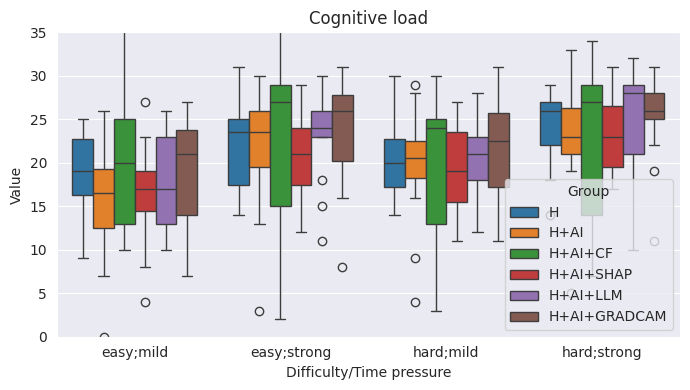

In [428]:
plot_boxplot_nested(
    cogload_processed,
    "Difficulty/Time pressure",
    dataset_name="Group",
    title="Cognitive load",
    y_lim=(0,35),
    y_line=None,
    figsize=(7, 4),
)

In [429]:

def plot_grouped_histograms(data, xlim, ylim=None, alpha=0.5, figsize=(12, 6), bins=None):
    """
    Plots histograms for nested group data.

    Parameters:
        data (dict):
            {
                "group1": {"groupA": [...], "groupB": [...], ...},
                "group2": {"groupA": [...], "groupB": [...], ...},
                ...
            }
        bins (int): Number of bins for histograms.
        alpha (float): Transparency for the overlapping histograms.
        figsize (tuple): Figure size.
    """

    # Get all subgroup names (e.g., groupA, groupB...)
    subgroups = sorted({sg for g in data.values() for sg in g.keys()})

    # Create one subplot per subgroup
    fig, axes = plt.subplots(1, len(subgroups), figsize=figsize, squeeze=False)
    axes = axes[0]

    # Prepare colors (matplotlib will cycle them automatically)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_map = {gname: colors[i % len(colors)] for i, gname in enumerate(data.keys())}

    for ax, subgroup in zip(axes, subgroups):
        for group_name, group_dict in data.items():
            if subgroup in group_dict:
                values = group_dict[subgroup]
                if values:  # skip empty lists
                    ax.hist(values, alpha=alpha,
                            label=group_name, color=color_map[group_name], bins=bins)

        ax.set_title(subgroup)
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")
        ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)
        ax.legend()

    plt.tight_layout()
    plt.show()


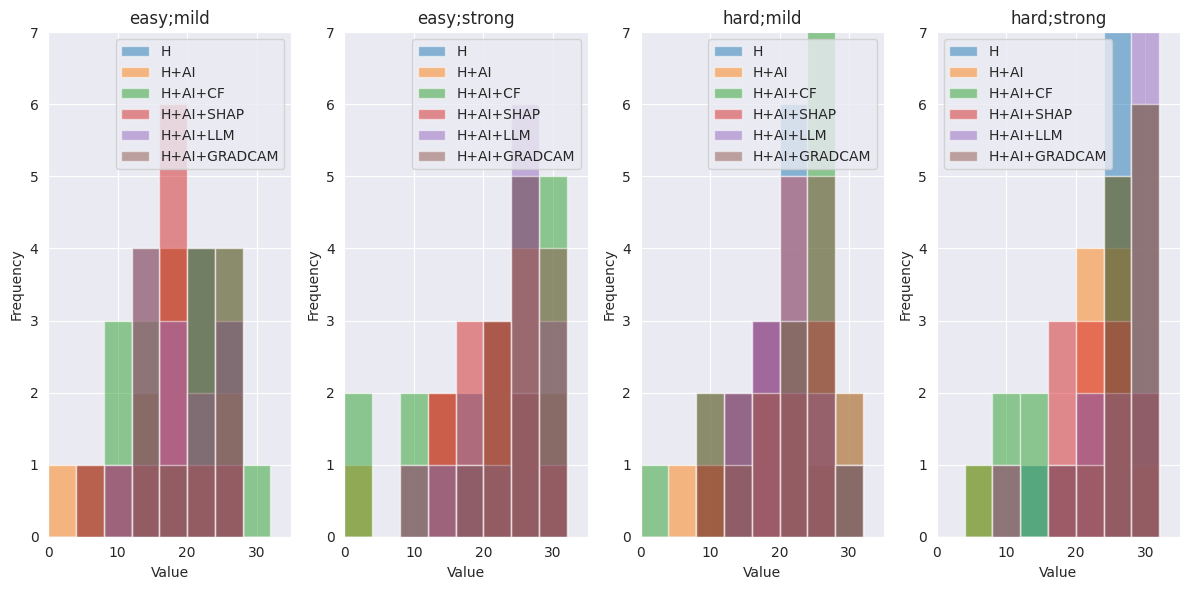

In [430]:
plot_grouped_histograms(cogload_processed, xlim=(0, 35), ylim=(0, 7), figsize=(12, 6), bins=np.arange(0, 35, 4))


In [431]:
quest_keys = ["mainexp_easy_mild_cogload", "mainexp_easy_strong_cogload", "mainexp_hard_mild_cogload",
              "mainexp_hard_strong_cogload"]

cogload_results = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, quest_keys)

66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
5b68c9eb87af310001584803.json
5c1575e62a407b0001ff2a4c.json
65e4a6bdde84e615dcac2651.json
65a3ec0d50e146d8bd324e1f.json
6458fe267afe71c7aa4de260.json
5b017ef1293d310001023bd8.json
5987030cfd8cca00015cbc26.json
66df195291efa52e95e957ae.json
6445b13023ac3b3eb202881f.json
5eaecb0824839e59ed3523eb.json
6130c7f7d0112fa23b17079c.json
5e96f7328eba7d1846709a07.json
5c2ebf3e626018000134986f.json
5f57be602095072bb238a7ab.json
5bae3351a91ee200011a4220.json
651c1d7524852e9f9d614ce3.json
66a8e5cfc411f4b77b49dff3.json
67693b69371357770f713607.json
59025280d17178000141a7dd.json
5c05510b89

In [432]:
# cogload_results

In [433]:
extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_1"])


66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
5b68c9eb87af310001584803.json
5c1575e62a407b0001ff2a4c.json
65e4a6bdde84e615dcac2651.json
65a3ec0d50e146d8bd324e1f.json
6458fe267afe71c7aa4de260.json
5b017ef1293d310001023bd8.json
5987030cfd8cca00015cbc26.json
66df195291efa52e95e957ae.json
6445b13023ac3b3eb202881f.json
5eaecb0824839e59ed3523eb.json
6130c7f7d0112fa23b17079c.json
5e96f7328eba7d1846709a07.json
5c2ebf3e626018000134986f.json
5f57be602095072bb238a7ab.json
5bae3351a91ee200011a4220.json
651c1d7524852e9f9d614ce3.json
66a8e5cfc411f4b77b49dff3.json
67693b69371357770f713607.json
59025280d17178000141a7dd.json
5c05510b89

{'H': {'raw': {'attentioncheck_1': [array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object),
    array([2, 0], dtype=object)]},
  'values': {'attentioncheck_1': [array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat Disagree', '(1) Blue'], dtype=object),
    array(['(3) Somewhat D

In [434]:

extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck_2"])


66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
5b68c9eb87af310001584803.json
5c1575e62a407b0001ff2a4c.json
65e4a6bdde84e615dcac2651.json
65a3ec0d50e146d8bd324e1f.json
6458fe267afe71c7aa4de260.json
5b017ef1293d310001023bd8.json
5987030cfd8cca00015cbc26.json
66df195291efa52e95e957ae.json
6445b13023ac3b3eb202881f.json
5eaecb0824839e59ed3523eb.json
6130c7f7d0112fa23b17079c.json
5e96f7328eba7d1846709a07.json
5c2ebf3e626018000134986f.json
5f57be602095072bb238a7ab.json
5bae3351a91ee200011a4220.json
651c1d7524852e9f9d614ce3.json
66a8e5cfc411f4b77b49dff3.json
67693b69371357770f713607.json
59025280d17178000141a7dd.json
5c05510b89

{'H': {'raw': {'attentioncheck_2': [array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object),
    array([6, 0], dtype=object)]},
  'values': {'attentioncheck_2': [array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
           '(1) Searching for patterns and their rotations'], dtype=object),
    array(['(7) Strongly Agree',
 

In [435]:
extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, ["attentioncheck2"])


66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
5b68c9eb87af310001584803.json
5c1575e62a407b0001ff2a4c.json
65e4a6bdde84e615dcac2651.json
65a3ec0d50e146d8bd324e1f.json
6458fe267afe71c7aa4de260.json
5b017ef1293d310001023bd8.json
5987030cfd8cca00015cbc26.json
66df195291efa52e95e957ae.json
6445b13023ac3b3eb202881f.json
5eaecb0824839e59ed3523eb.json
6130c7f7d0112fa23b17079c.json
5e96f7328eba7d1846709a07.json
5c2ebf3e626018000134986f.json
5f57be602095072bb238a7ab.json
5bae3351a91ee200011a4220.json
651c1d7524852e9f9d614ce3.json
66a8e5cfc411f4b77b49dff3.json
67693b69371357770f713607.json
59025280d17178000141a7dd.json
5c05510b89

{'H': {'raw': {'attentioncheck2': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None]},
  'values': {'attentioncheck2': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None]},
  'times': {'attentioncheck2': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None]}},
 'H+AI': {'raw': {'attentioncheck2': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None]},
  'values': {'attentioncheck2': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None]},
  'times': {'attentioncheck2': [None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None,
    None]}},
 'H+AI+CF': {'raw': {'atten

In [436]:
def process_reliance_list_data(reliance_data_list):

    output_trust = None

    if len(reliance_data_list) > 0:
        output_trust = reliance_data_list[0]

    return output_trust

def extract_declared_reliance_data(results_dir, results_filenames_d, protocol_paths_d):

    output_d = {}

    form_keys = ["mainexp_easy_mild_reliance",
            "mainexp_easy_strong_reliance",
            "mainexp_hard_mild_reliance",
            "mainexp_hard_strong_reliance"]

    data = extract_quest_results(results_dir, results_filenames_d, protocol_paths_d, form_keys)

    for key_group, data in data.items():
        output_d[key_group] = {}

        for form_key in form_keys:
            output_d[key_group][form_key] = {
                "trust": [],
            }

            if form_key not in data["raw"]:
                continue

            for arr in data["raw"][form_key]:
                trust = process_reliance_list_data(arr) if arr is not None else None

                if trust is not None:
                    output_d[key_group][form_key]["trust"].append(trust)

    return output_d


In [437]:
processed_reliance_data = extract_declared_reliance_data(results_dir, results_filenames_d, protocol_paths_d)


66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
5b68c9eb87af310001584803.json
5c1575e62a407b0001ff2a4c.json
65e4a6bdde84e615dcac2651.json
65a3ec0d50e146d8bd324e1f.json
6458fe267afe71c7aa4de260.json
5b017ef1293d310001023bd8.json
5987030cfd8cca00015cbc26.json
66df195291efa52e95e957ae.json
6445b13023ac3b3eb202881f.json
5eaecb0824839e59ed3523eb.json
6130c7f7d0112fa23b17079c.json
5e96f7328eba7d1846709a07.json
5c2ebf3e626018000134986f.json
5f57be602095072bb238a7ab.json
5bae3351a91ee200011a4220.json
651c1d7524852e9f9d614ce3.json
66a8e5cfc411f4b77b49dff3.json
67693b69371357770f713607.json
59025280d17178000141a7dd.json
5c05510b89

In [438]:
processed_reliance_data

{'H': {'mainexp_easy_mild_reliance': {'trust': []},
  'mainexp_easy_strong_reliance': {'trust': []},
  'mainexp_hard_mild_reliance': {'trust': []},
  'mainexp_hard_strong_reliance': {'trust': []}},
 'H+AI': {'mainexp_easy_mild_reliance': {'trust': [6,
    5,
    1,
    3,
    4,
    4,
    5,
    4,
    5,
    4,
    2,
    1]},
  'mainexp_easy_strong_reliance': {'trust': [6,
    5,
    1,
    3,
    5,
    5,
    5,
    4,
    5,
    4,
    3,
    6]},
  'mainexp_hard_mild_reliance': {'trust': [6,
    5,
    2,
    2,
    4,
    5,
    5,
    4,
    5,
    2,
    3,
    2]},
  'mainexp_hard_strong_reliance': {'trust': [6,
    5,
    3,
    4,
    4,
    5,
    4,
    4,
    5,
    5,
    3,
    0]}},
 'H+AI+CF': {'mainexp_easy_mild_reliance': {'trust': [4,
    4,
    1,
    3,
    0,
    3,
    4,
    1,
    4,
    4,
    6,
    0,
    5,
    3,
    3,
    2,
    4]},
  'mainexp_easy_strong_reliance': {'trust': [4,
    6,
    3,
    3,
    4,
    4,
    5,
    3,
    4,
    4,
    6,


In [439]:
def get_data_for_reliance_plots(processed_reliance_data, target_key):

    output_d = {k: {} for k in results_filenames_d.keys()}

    for group_key, group_data in processed_reliance_data.items():
        for form_key, form_data in group_data.items():
            output_d[group_key][form_key] = form_data[target_key]

    return output_d



In [440]:
declared_trust_plot_data = get_data_for_reliance_plots(processed_reliance_data, "trust")

In [441]:
declared_trust_plot_data

{'H': {'mainexp_easy_mild_reliance': [],
  'mainexp_easy_strong_reliance': [],
  'mainexp_hard_mild_reliance': [],
  'mainexp_hard_strong_reliance': []},
 'H+AI': {'mainexp_easy_mild_reliance': [6, 5, 1, 3, 4, 4, 5, 4, 5, 4, 2, 1],
  'mainexp_easy_strong_reliance': [6, 5, 1, 3, 5, 5, 5, 4, 5, 4, 3, 6],
  'mainexp_hard_mild_reliance': [6, 5, 2, 2, 4, 5, 5, 4, 5, 2, 3, 2],
  'mainexp_hard_strong_reliance': [6, 5, 3, 4, 4, 5, 4, 4, 5, 5, 3, 0]},
 'H+AI+CF': {'mainexp_easy_mild_reliance': [4,
   4,
   1,
   3,
   0,
   3,
   4,
   1,
   4,
   4,
   6,
   0,
   5,
   3,
   3,
   2,
   4],
  'mainexp_easy_strong_reliance': [4,
   6,
   3,
   3,
   4,
   4,
   5,
   3,
   4,
   4,
   6,
   0,
   5,
   3,
   4,
   3,
   4],
  'mainexp_hard_mild_reliance': [2,
   4,
   6,
   3,
   3,
   3,
   4,
   1,
   4,
   4,
   5,
   0,
   4,
   4,
   3,
   3,
   4],
  'mainexp_hard_strong_reliance': [4,
   5,
   6,
   3,
   3,
   4,
   4,
   3,
   4,
   4,
   6,
   0,
   5,
   3,
   3,
   2,
   4]},
 'H+A

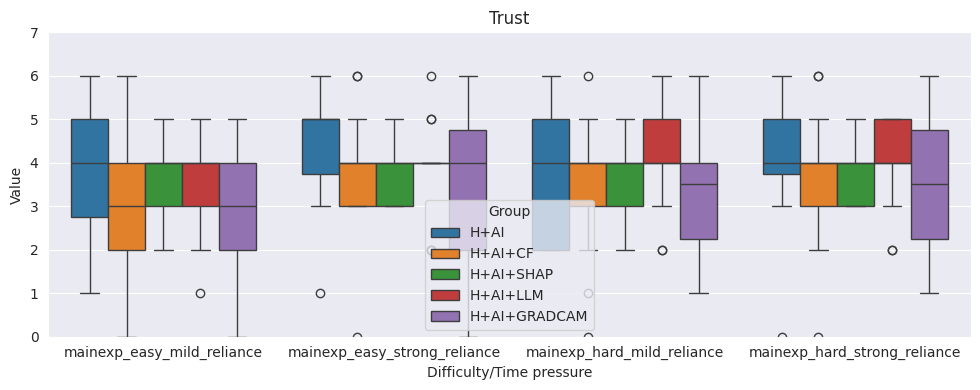

In [442]:
plot_boxplot_nested(
    declared_trust_plot_data,
    "Difficulty/Time pressure",
    dataset_name="Group",
    title="Trust",
    y_lim=(0,7),
    y_line=None,
    figsize=(10, 4),
)

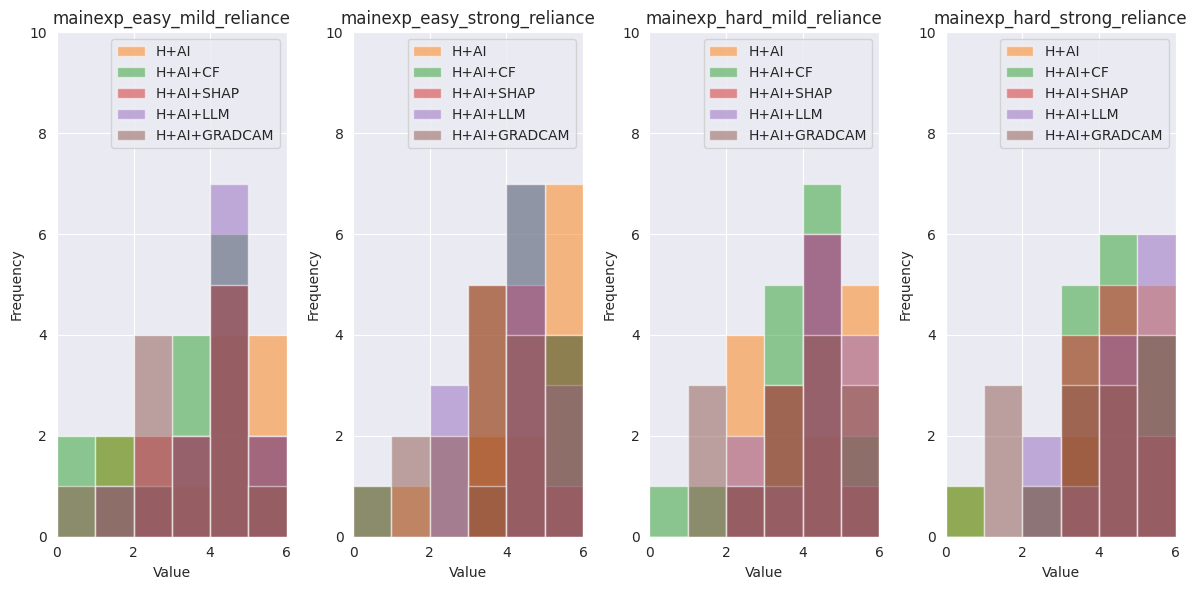

In [443]:
plot_grouped_histograms(declared_trust_plot_data, xlim=(0, 6), ylim=(0, 10), figsize=(12, 6), bins=np.arange(7))


In [444]:
all_reliance_strong

{'H': [0.625,
  0.6666666666666666,
  0.8333333333333334,
  0.625,
  0.625,
  0.5,
  0.625,
  0.5833333333333334,
  0.5416666666666666,
  0.5,
  0.7083333333333334,
  0.5833333333333334,
  0.625,
  0.625],
 'H+AI': [0.9583333333333334,
  0.8333333333333334,
  0.7916666666666666,
  0.875,
  0.9583333333333334,
  1.0,
  0.875,
  1.0,
  1.0,
  0.9583333333333334,
  0.625,
  0.8333333333333334],
 'H+AI+CF': [0.7083333333333334,
  0.9166666666666666,
  0.9583333333333334,
  0.9583333333333334,
  0.7916666666666666,
  0.9583333333333334,
  0.7916666666666666,
  0.9583333333333334,
  0.875,
  0.6666666666666666,
  0.9583333333333334,
  0.5416666666666666,
  0.7916666666666666,
  0.5,
  1.0,
  1.0,
  0.8333333333333334],
 'H+AI+SHAP': [0.7916666666666666,
  0.7083333333333334,
  0.6666666666666666,
  1.0,
  0.75,
  0.7916666666666666,
  1.0,
  0.75,
  0.75,
  0.8333333333333334,
  0.7083333333333334],
 'H+AI+LLM': [0.9166666666666666,
  0.875,
  1.0,
  0.9166666666666666,
  0.6666666666666666,

In [445]:
scores_easy_mild, reliance_easy_mild, overreliance_easy_mild, underreliance_easy_mild, answertimes_easy_mild= compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["easy1_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_easy_strong, reliance_easy_strong, overreliance_easy_strong, underreliance_easy_strong, answertimes_easy_strong = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["easy3_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_hard_mild, reliance_hard_mild, overreliance_hard_mild, underreliance_hard_mild, answertimes_hard_mild = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["hard1_find_pattern_rot"], TASK_PROTOCOL_KEYS)
scores_hard_strong, reliance_hard_strong, overreliance_hard_strong, underreliance_hard_strong, answertimes_hard_strong = compute_scores(results_dir, results_filenames_d, protocol_paths_d, tasks_dir, ["hard3_find_pattern_rot"], TASK_PROTOCOL_KEYS)


66c9f7305f8a64d04cb5344c.json
6658b23d488052210af6eb17.json
5fe0b183d8918b2030aa99a0.json
6777c88074566bdef374f9e5.json
66bdde69417a86ba178f7871.json
66dd8fd2905d609d29ccf008.json
60a7af637db81b5c05648d92.json
5b2e41eb1d2f710001fb32db.json
5b2a2d855b5c0900018b0bf5.json
671c1c699ca32031a83014e8.json
665dc46f6552a7a3a0039fe6.json
5fb281433a31c686f0ec3ecb.json
6033aebb7228c70967a3ab43.json
63f77a5dde1ea03305e119e0.json
5b68c9eb87af310001584803.json
5c1575e62a407b0001ff2a4c.json
65e4a6bdde84e615dcac2651.json
65a3ec0d50e146d8bd324e1f.json
6458fe267afe71c7aa4de260.json
5b017ef1293d310001023bd8.json
5987030cfd8cca00015cbc26.json
66df195291efa52e95e957ae.json
6445b13023ac3b3eb202881f.json
5eaecb0824839e59ed3523eb.json
6130c7f7d0112fa23b17079c.json
5e96f7328eba7d1846709a07.json
5c2ebf3e626018000134986f.json
5f57be602095072bb238a7ab.json
5bae3351a91ee200011a4220.json
651c1d7524852e9f9d614ce3.json
66a8e5cfc411f4b77b49dff3.json
67693b69371357770f713607.json
59025280d17178000141a7dd.json
5c05510b89

In [446]:
processed_reliance_data

{'H': {'mainexp_easy_mild_reliance': {'trust': []},
  'mainexp_easy_strong_reliance': {'trust': []},
  'mainexp_hard_mild_reliance': {'trust': []},
  'mainexp_hard_strong_reliance': {'trust': []}},
 'H+AI': {'mainexp_easy_mild_reliance': {'trust': [6,
    5,
    1,
    3,
    4,
    4,
    5,
    4,
    5,
    4,
    2,
    1]},
  'mainexp_easy_strong_reliance': {'trust': [6,
    5,
    1,
    3,
    5,
    5,
    5,
    4,
    5,
    4,
    3,
    6]},
  'mainexp_hard_mild_reliance': {'trust': [6,
    5,
    2,
    2,
    4,
    5,
    5,
    4,
    5,
    2,
    3,
    2]},
  'mainexp_hard_strong_reliance': {'trust': [6,
    5,
    3,
    4,
    4,
    5,
    4,
    4,
    5,
    5,
    3,
    0]}},
 'H+AI+CF': {'mainexp_easy_mild_reliance': {'trust': [4,
    4,
    1,
    3,
    0,
    3,
    4,
    1,
    4,
    4,
    6,
    0,
    5,
    3,
    3,
    2,
    4]},
  'mainexp_easy_strong_reliance': {'trust': [4,
    6,
    3,
    3,
    4,
    4,
    5,
    3,
    4,
    4,
    6,


In [447]:
all_times_easy

{'H': [3.0,
  7.8,
  9.1,
  4.8,
  5.0,
  13.3,
  6.6,
  8.5,
  7.3,
  7.0,
  8.5,
  7.5,
  3.0,
  0.7,
  1.3,
  1.2,
  3.2,
  8.0,
  1.6,
  1.5,
  1.5,
  2.1,
  2.2,
  2.4,
  2.6,
  5.4,
  7.1,
  4.4,
  6.7,
  9.2,
  4.9,
  5.0,
  8.6,
  3.3,
  4.4,
  4.0,
  6.2,
  2.4,
  6.0,
  2.8,
  2.9,
  3.3,
  2.3,
  2.7,
  4.0,
  4.7,
  6.0,
  6.1,
  2.6,
  5.7,
  7.2,
  4.9,
  4.4,
  19.5,
  5.4,
  6.6,
  4.3,
  4.2,
  6.9,
  4.1,
  10.0,
  2.9,
  4.6,
  3.7,
  3.6,
  4.4,
  8.0,
  4.3,
  4.1,
  4.0,
  6.4,
  5.8,
  3.9,
  9.8,
  12.4,
  10.8,
  14.3,
  15.9,
  8.0,
  5.7,
  19.9,
  7.0,
  11.3,
  13.0,
  8.6,
  3.8,
  7.4,
  10.0,
  4.3,
  6.7,
  7.8,
  5.5,
  5.1,
  6.9,
  4.7,
  6.4,
  4.0,
  8.6,
  13.5,
  8.1,
  7.2,
  15.3,
  6.5,
  7.6,
  7.2,
  8.6,
  7.1,
  16.2,
  6.8,
  4.1,
  3.8,
  4.5,
  2.8,
  5.8,
  8.9,
  5.6,
  5.2,
  5.7,
  6.4,
  6.8,
  7.8,
  18.9,
  10.8,
  12.4,
  11.4,
  23.3,
  10.8,
  10.9,
  19.7,
  13.9,
  11.2,
  14.9,
  8.2,
  10.0,
  10.0,
  7.0,
  10.0,
  8.7,
 

In [448]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_histogram_with_density(data_dict, title="Histogram with Density", xlabel="Value", ylabel="Density"):
    """
    Plots a histogram with density (KDE) for each group in the data dictionary.

    Parameters:
    - data_dict: Dictionary of the form {"group1": [values], "group2": [values], ...}
    - title: Title of the plot
    - xlabel: Label for the x-axis
    - ylabel: Label for the y-axis
    """
    # Convert the dictionary to a DataFrame for easier plotting
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_dict.items()]))

    # Melt the DataFrame for seaborn
    df_melted = df.melt(var_name='groups', value_name='values')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df_melted, x='values', hue='groups', kde=True, element='step', stat='density', common_norm=False)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()



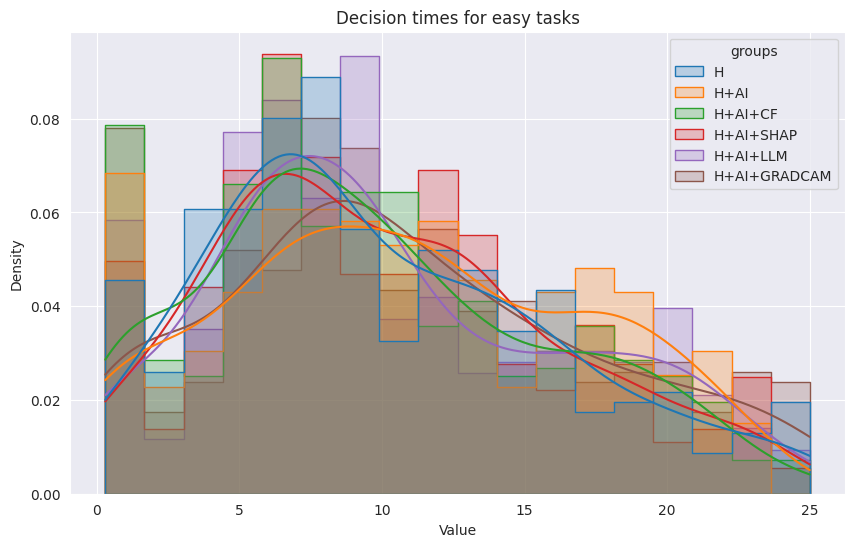

In [449]:
plot_histogram_with_density(all_times_mild, title="Decision times for easy tasks")

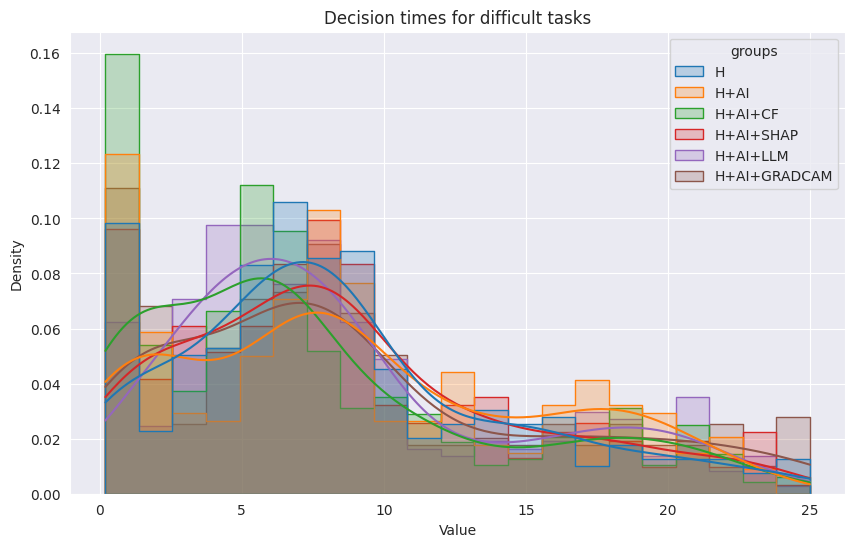

In [450]:
plot_histogram_with_density(all_times_difficult, title="Decision times for difficult tasks")

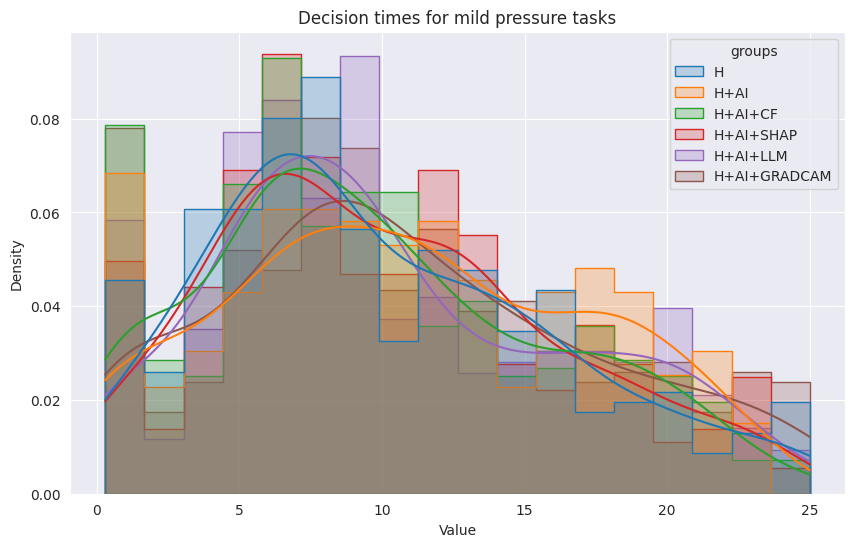

In [451]:
plot_histogram_with_density(all_times_mild, title="Decision times for mild pressure tasks")

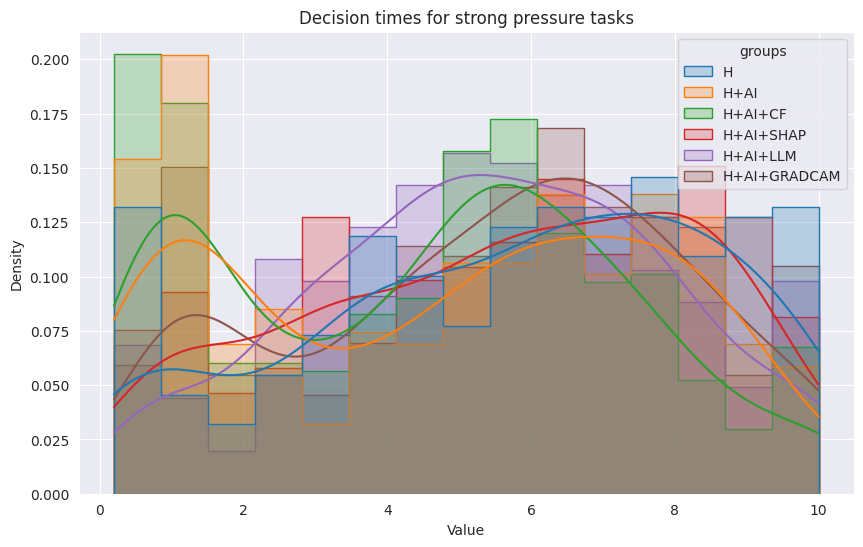

In [452]:
plot_histogram_with_density(all_times_strong, title="Decision times for strong pressure tasks")

In [453]:
N_per_group = 50

In [454]:
reliance_easy_mild["H+AI+SHAP"] = np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_easy_strong["H+AI+SHAP"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()
reliance_hard_mild["H+AI+SHAP"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()
reliance_hard_strong["H+AI+SHAP"] =  np.random.normal(0.9, 0.1, N_per_group).tolist()

reliance_easy_mild["H+AI+CF"] = np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_easy_strong["H+AI+CF"] =  np.random.normal(0.65, 0.1, N_per_group).tolist()
reliance_hard_mild["H+AI+CF"] =  np.random.normal(0.6, 0.1, N_per_group).tolist()
reliance_hard_strong["H+AI+CF"] =  np.random.normal(0.7, 0.1, N_per_group).tolist()

reliance_easy_mild["H"] = np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_easy_strong["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_hard_mild["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()
reliance_hard_strong["H"] =  np.random.normal(0.5, 0.1, N_per_group).tolist()


In [455]:
reliance_easy_mild

{'H': [0.377716075040658,
  0.4061623005665498,
  0.5139831902532055,
  0.33379038222466006,
  0.4522637653787871,
  0.6522442034663578,
  0.42045872615005775,
  0.46171174781988555,
  0.5311989097313055,
  0.21513324616270652,
  0.4371108951615561,
  0.5859792097092884,
  0.5119402672416017,
  0.6065375188529818,
  0.713972398157866,
  0.4878874008979016,
  0.6549945536991298,
  0.33114788023021646,
  0.5475046598906028,
  0.6203945727331918,
  0.5004539188838949,
  0.5283166520636071,
  0.5094593163156216,
  0.681546804107761,
  0.48849957891956736,
  0.5103647357726269,
  0.6162999543664519,
  0.4681627042516574,
  0.5299326146417831,
  0.5751734829942093,
  0.6673520309482378,
  0.5810648970132035,
  0.5118293489321739,
  0.44291658442472004,
  0.40671355025070366,
  0.5227132867729976,
  0.3753076327691832,
  0.5460436415776203,
  0.32116777197670976,
  0.7473639636696638,
  0.545905389786234,
  0.48320845593502615,
  0.44594228394522345,
  0.7125302763056448,
  0.553767246489813,

In [456]:
def create_df():
    data_participants = []
    data_difficulty = []
    data_pressure = []
    data_reliance = []
    data_overreliance = []
    data_underreliance = []
    data_answertimes = []
    data_scores = []
    data_xai_condition = []
    data_trust = []

    for xai_condition in ["H", "H+AI", "H+AI+SHAP", "H+AI+CF", "H+AI+GRADCAM", "H+AI+LLM"]:

        data_reliance.extend(reliance_easy_mild[xai_condition])
        data_overreliance.extend(overreliance_easy_mild[xai_condition])
        data_underreliance.extend(underreliance_easy_mild[xai_condition])
        data_answertimes.extend(answertimes_easy_mild[xai_condition])
        data_scores.extend(scores_easy_mild[xai_condition])
        curr_trust_data = processed_reliance_data[xai_condition]["mainexp_easy_mild_reliance"]["trust"]
        data_trust.extend(curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_difficulty.extend(["easy" for k in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["mild" for k in range(len(reliance_easy_mild[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_easy_mild[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_easy_mild[xai_condition]))])

        data_reliance.extend(reliance_easy_strong[xai_condition])
        data_overreliance.extend(overreliance_easy_strong[xai_condition])
        data_underreliance.extend(underreliance_easy_strong[xai_condition])
        data_answertimes.extend(answertimes_easy_strong[xai_condition])
        data_scores.extend(scores_easy_strong[xai_condition])
        data_difficulty.extend(["easy" for k in range(len(reliance_easy_strong[xai_condition]))])
        curr_trust_data = processed_reliance_data[xai_condition]["mainexp_easy_strong_reliance"]["trust"]
        data_trust.extend(curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["strong" for k in range(len(reliance_easy_strong[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_easy_strong[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_easy_strong[xai_condition]))])

        data_reliance.extend(reliance_hard_mild[xai_condition])
        data_overreliance.extend(overreliance_hard_mild[xai_condition])
        data_underreliance.extend(underreliance_hard_mild[xai_condition])
        data_answertimes.extend(answertimes_hard_mild[xai_condition])
        data_scores.extend(scores_hard_mild[xai_condition])
        data_difficulty.extend(["hard" for k in range(len(reliance_hard_mild[xai_condition]))])
        curr_trust_data = processed_reliance_data[xai_condition]["mainexp_hard_mild_reliance"]["trust"]
        data_trust.extend(curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["mild" for k in range(len(reliance_hard_mild[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_hard_mild[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_hard_mild[xai_condition]))])

        data_reliance.extend(reliance_hard_strong[xai_condition])
        data_overreliance.extend(overreliance_hard_strong[xai_condition])
        data_underreliance.extend(underreliance_hard_strong[xai_condition])
        data_answertimes.extend(answertimes_hard_strong[xai_condition])
        data_scores.extend(scores_hard_strong[xai_condition])
        data_difficulty.extend(["hard" for k in range(len(reliance_hard_strong[xai_condition]))])
        curr_trust_data = processed_reliance_data[xai_condition]["mainexp_hard_strong_reliance"]["trust"]
        data_trust.extend(curr_trust_data if curr_trust_data else [None for i in range(len(reliance_easy_mild[xai_condition]))])
        data_pressure.extend(["strong" for k in range(len(reliance_hard_strong[xai_condition]))])
        data_participants.extend([i+1 for i in range(len(reliance_hard_strong[xai_condition]))])
        data_xai_condition.extend([xai_condition for k in range(len(reliance_hard_strong[xai_condition]))])

    print(len(data_participants))
    print(len(data_difficulty))
    print(len(data_pressure))
    print(len(data_reliance))
    print(len(data_overreliance))
    print(len(data_underreliance))
    print(len(data_scores))
    print(len(data_trust))
    print(len(data_xai_condition))
    return pd.DataFrame({
        "participant": data_participants,
        "difficulty": data_difficulty,
        "pressure": data_pressure,
        "reliance": data_reliance,
        "overreliance": data_overreliance,
        "underreliance": data_underreliance,
        "score": data_scores,
        # "trust": data_trust,
        "xai_condition": data_xai_condition
    })


In [457]:
df = create_df()
# df["participant"] = df["participant"].astype("category")
df["pressure"] = df["pressure"].astype("category")
df["difficulty"] = df["difficulty"].astype("category")
df["xai_condition"] = df["xai_condition"].astype("category")

df["pressure"] = pd.Categorical(
    df["pressure"],
    categories=["mild", "strong"],
    ordered=True
)

df["difficulty"] = pd.Categorical(
    df["difficulty"],
    categories=["easy", "hard"],
    ordered=True
)

df["xai_condition"] = pd.Categorical(
    df["xai_condition"],
    categories=["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"],
    ordered=False
)


756
756
756
756
324
324
324
468
756


ValueError: All arrays must be of the same length

## Test of hypotheses

### Hypotheses 1 (related to time pressure)
Each hypothesis is tested for every group with AI, against the data of the same group
with no time pressure/difficulty. Effects of pressure and
difficulty are studied independently + their interaction

* (1.a) Higher time pressure and higher difficulty increase reliance.

In [34]:
from statsmodels.stats.multitest import multipletests
import statsmodels.formula.api as smf

pvals_pressure = []
pvals_difficulty = []
pvals_both = []
labels = []
for xai_group in ["H", "H+AI", "H+AI+CF", "H+AI+SHAP", "H+AI+LLM", "H+AI+GRADCAM"]:

    df_group = df[df["xai_condition"] == xai_group]
    print(xai_group)
    model = smf.mixedlm(
        "reliance ~ pressure * difficulty",
        df_group,
        groups=df_group["participant"]
    )
    result = model.fit()

    pval_pressure = result.pvalues["pressure[T.strong]"]
    pval_difficulty = result.pvalues["difficulty[T.hard]"]
    pval_both = result.pvalues["pressure[T.strong]:difficulty[T.hard]"]
    pvals_pressure.append(pval_pressure)
    pvals_difficulty.append(pval_difficulty)
    pval_both.append(pval_both)
    labels.append(xai_group)

    print(result.summary())

def show_holm_results(pvals):
    reject, pvals_holm, _, _ = multipletests(
        pvals,
        alpha=0.05,
        method="holm"
    )

    for g, p_raw, p_adj, sig in zip(labels, pvals_difficulty, pvals_holm, reject):
        print(
            f"{g:12s}  raw p = {p_raw:.4f}  "
            f"Holm p = {p_adj:.4f}  "
            f"{'SIGNIFICANT' if sig else 'ns'}"
        )

print("Pressure")
show_holm_results(pvals_pressure)

print("Difficulty")
show_holm_results(pvals_difficulty)

print("Both")
show_holm_results(pvals_both)


NameError: name 'df' is not defined

* (1.b) Higher time pressure and higher difficulty increase overreliance.

In [358]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "overreliance ~ pressure * difficulty * xai_condition",
    df,
    groups=df["participant"]
)

result = model.fit()
print(result.summary())

                                    Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  overreliance
No. Observations:                   260                      Method:                              REML        
No. Groups:                         14                       Scale:                               0.1214      
Min. group size:                    4                        Log-Likelihood:                      -119.5046   
Max. group size:                    24                       Converged:                           Yes         
Mean group size:                    18.6                                                                      
--------------------------------------------------------------------------------------------------------------
                                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


* (1.c) Higher time pressure and higher difficulty decrease trust.


In [364]:
df_H1c = df[df["xai_condition"] != "H"]

In [366]:
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "trust ~ pressure * difficulty * xai_condition",
    data=df_H1c,
    groups=df_H1c["participant"]
)

result = model.fit()
print(result.summary())

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                                             Mixed Linear Model Regression Results
Model:                                    MixedLM                         Dependent Variable:                         trust    
No. Observations:                         224                             Method:                                     REML     
No. Groups:                               14                              Scale:                                      1.7821   
Min. group size:                          4                               Log-Likelihood:                             -309.8241
Max. group size:                          20                              Converged:                                  No       
Mean group size:                          16.0                                                                                 
-------------------------------------------------------------------------------------------------------------------------------
                     

/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/home/jleguy/anaconda3/envs/Pytorch_exp/lib/python3.12